In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()
        
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    


class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)


class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta*self.adjust_a(2*Euv)
        self.beta = self.beta + eta*self.adjust_b(Ev)
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [3]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
    
#     print(abs(network.n1.beta.max(0)[0]).max(0))
    print("Largest beta is ", max(abs(network.n1.beta.max(0)[0]).max(0),
                   abs(network.n2.beta.max(0)[0]).max(0),
                   abs(network.n3.beta.max(0)[0]).max(0),
                   abs(network.n4.beta.max(0)[0]).max(0),
                   abs(network.n5.beta.max(0)[0]).max(0),
                   abs(network.n6.beta.max(0)[0]).max(0),
                   abs(network.n7.beta.max(0)[0]).max(0),
                   abs(network.n8.beta.max(0)[0]).max(0)))
    print("Largest weight is ", max(abs(network.fc1.weight.max(0)[0]).max(0),
              abs(network.fc2.weight.max(0)[0]).max(0),
              abs(network.fc3.weight.max(0)[0]).max(0),
              abs(network.fc4.weight.max(0)[0]).max(0),
              abs(network.fc5.weight.max(0)[0]).max(0),
              abs(network.fc6.weight.max(0)[0]).max(0),
              abs(network.fc7.weight.max(0)[0]).max(0),
              abs(network.fc8.weight.max(0)[0]).max(0)))
    
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Tests

In [5]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 20

int_lr = 0.0001

Training IP Net. Run 1
[1] loss: 1.242
[2] loss: 0.544
[3] loss: 0.327
[4] loss: 0.251
[5] loss: 0.206
[6] loss: 0.176
[7] loss: 0.150
[8] loss: 0.135
[9] loss: 0.123
[10] loss: 0.111
[11] loss: 0.100
[12] loss: 0.094
[13] loss: 0.085
[14] loss: 0.081
[15] loss: 0.071
[16] loss: 0.067
[17] loss: 0.064
[18] loss: 0.061
[19] loss: 0.056
[20] loss: 0.054
Largest beta is  (tensor(0.6903, device='cuda:0'), tensor(49, device='cuda:0'))
Largest weight is  (tensor(0.9083, device='cuda:0'), tensor(48, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.240
[2] loss: 0.507
[3] loss: 0.282
[4] loss: 0.214
[5] loss: 0.174
[6] loss: 0.149
[7] loss: 0.130
[8] loss: 0.116
[9] loss: 0.100
[10] loss: 0.091
[11] loss: 0.082
[12] loss: 0.075
[13] loss: 0.071
[14] loss: 0.063
[15] loss: 0.061
[16] loss: 0.059
[17] loss: 0.056
[18] loss: 0.048
[19] loss: 0.045
[20] loss: 0.046
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.

[8] loss: 0.109
[9] loss: 0.098
[10] loss: 0.091
[11] loss: 0.080
[12] loss: 0.078
[13] loss: 0.070
[14] loss: 0.064
[15] loss: 0.060
[16] loss: 0.056
[17] loss: 0.054
[18] loss: 0.051
[19] loss: 0.047
[20] loss: 0.043
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.7865, device='cuda:0'), tensor(769, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 1.107
[2] loss: 0.364
[3] loss: 0.243
[4] loss: 0.187
[5] loss: 0.158
[6] loss: 0.136
[7] loss: 0.124
[8] loss: 0.110
[9] loss: 0.098
[10] loss: 0.091
[11] loss: 0.088
[12] loss: 0.078
[13] loss: 0.074
[14] loss: 0.067
[15] loss: 0.067
[16] loss: 0.057
[17] loss: 0.053
[18] loss: 0.051
[19] loss: 0.048
[20] loss: 0.047
Largest beta is  (tensor(0.6780, device='cuda:0'), tensor(30, device='cuda:0'))
Largest weight is  (tensor(0.7282, device='cuda:0'), tensor(377, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.147
[2] loss: 0.602
[3] l

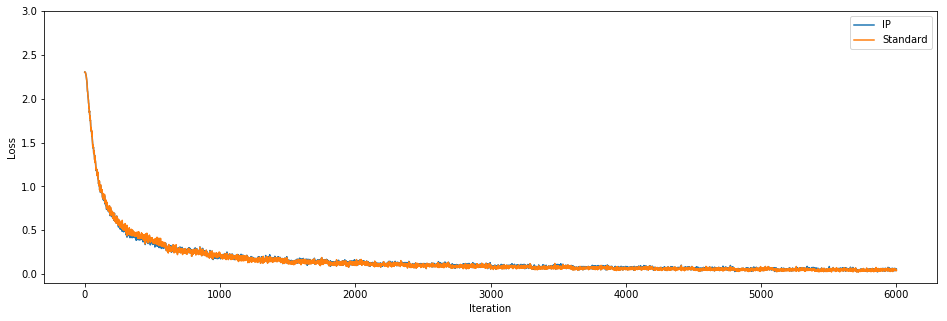

In [7]:
syn_lr = 0.001

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.045
[2] loss: 0.316
[3] loss: 0.221
[4] loss: 0.176
[5] loss: 0.149
[6] loss: 0.129
[7] loss: 0.113
[8] loss: 0.101
[9] loss: 0.093
[10] loss: 0.085
[11] loss: 0.080
[12] loss: 0.072
[13] loss: 0.068
[14] loss: 0.067
[15] loss: 0.068
[16] loss: 0.062
[17] loss: 0.060
[18] loss: 0.058
[19] loss: 0.057
[20] loss: 0.056
Largest beta is  (tensor(0.6450, device='cuda:0'), tensor(5, device='cuda:0'))
Largest weight is  (tensor(1.4761, device='cuda:0'), tensor(398, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.028
[2] loss: 0.313
[3] loss: 0.220
[4] loss: 0.173
[5] loss: 0.144
[6] loss: 0.130
[7] loss: 0.115
[8] loss: 0.106
[9] loss: 0.098
[10] loss: 0.091
[11] loss: 0.085
[12] loss: 0.090
[13] loss: 0.078
[14] loss: 0.075
[15] loss: 0.069
[16] loss: 0.072
[17] loss: 0.064
[18] loss: 0.065
[19] loss: 0.060
[20] loss: 0.061
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.

[8] loss: 0.098
[9] loss: 0.090
[10] loss: 0.083
[11] loss: 0.077
[12] loss: 0.075
[13] loss: 0.069
[14] loss: 0.065
[15] loss: 0.062
[16] loss: 0.062
[17] loss: 0.058
[18] loss: 0.059
[19] loss: 0.055
[20] loss: 0.052
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.8851, device='cuda:0'), tensor(299, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.770
[2] loss: 0.287
[3] loss: 0.208
[4] loss: 0.168
[5] loss: 0.143
[6] loss: 0.122
[7] loss: 0.113
[8] loss: 0.097
[9] loss: 0.092
[10] loss: 0.085
[11] loss: 0.078
[12] loss: 0.074
[13] loss: 0.068
[14] loss: 0.066
[15] loss: 0.065
[16] loss: 0.065
[17] loss: 0.055
[18] loss: 0.058
[19] loss: 0.057
[20] loss: 0.058
Largest beta is  (tensor(0.6495, device='cuda:0'), tensor(43, device='cuda:0'))
Largest weight is  (tensor(1.4358, device='cuda:0'), tensor(542, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 0.782
[2] loss: 0.293
[3] l

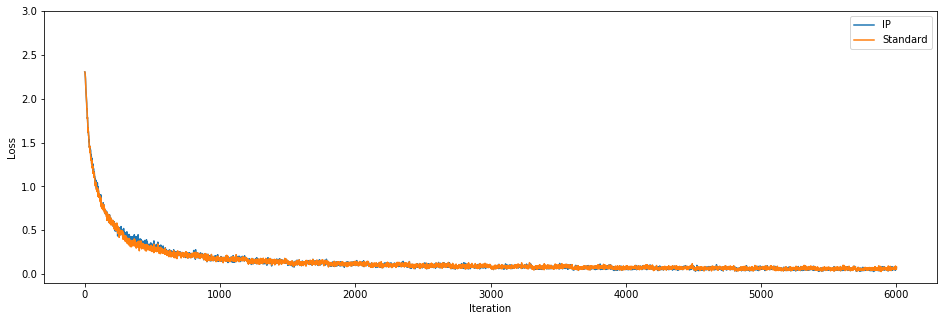

In [8]:
syn_lr = 0.003

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.642
[2] loss: 0.389
[3] loss: 0.333
[4] loss: 0.335
[5] loss: 0.336
[6] loss: 0.309
[7] loss: 0.318
[8] loss: 0.323
[9] loss: 0.334
[10] loss: 0.333
[11] loss: 0.352
[12] loss: 0.335
[13] loss: 0.348
[14] loss: 0.353
[15] loss: 0.365
[16] loss: 0.352
[17] loss: 0.359
[18] loss: 0.348
[19] loss: 0.337
[20] loss: 0.312
Largest beta is  (tensor(0.6191, device='cuda:0'), tensor(13, device='cuda:0'))
Largest weight is  (tensor(4.4885, device='cuda:0'), tensor(514, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 0.652
[2] loss: 0.393
[3] loss: 0.384
[4] loss: 0.347
[5] loss: 0.328
[6] loss: 0.328
[7] loss: 0.324
[8] loss: 0.317
[9] loss: 0.345
[10] loss: 0.333
[11] loss: 0.348
[12] loss: 0.376
[13] loss: 0.361
[14] loss: 0.363
[15] loss: 0.365
[16] loss: 0.385
[17] loss: 0.357
[18] loss: 0.377
[19] loss: 0.407
[20] loss: 0.396
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4

[8] loss: 0.331
[9] loss: 0.318
[10] loss: 0.320
[11] loss: 0.331
[12] loss: 0.347
[13] loss: 0.351
[14] loss: 0.373
[15] loss: 0.417
[16] loss: 0.388
[17] loss: 0.365
[18] loss: 0.393
[19] loss: 0.382
[20] loss: 0.395
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4.0334, device='cuda:0'), tensor(514, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.890
[2] loss: 0.499
[3] loss: 0.455
[4] loss: 0.395
[5] loss: 0.363
[6] loss: 0.348
[7] loss: 0.351
[8] loss: 0.341
[9] loss: 0.331
[10] loss: 0.321
[11] loss: 0.319
[12] loss: 0.307
[13] loss: 0.323
[14] loss: 0.311
[15] loss: 0.321
[16] loss: 0.325
[17] loss: 0.332
[18] loss: 0.365
[19] loss: 0.356
[20] loss: 0.418
Largest beta is  (tensor(0.6646, device='cuda:0'), tensor(44, device='cuda:0'))
Largest weight is  (tensor(4.2931, device='cuda:0'), tensor(97, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.155
[2] loss: 0.662
[3] lo

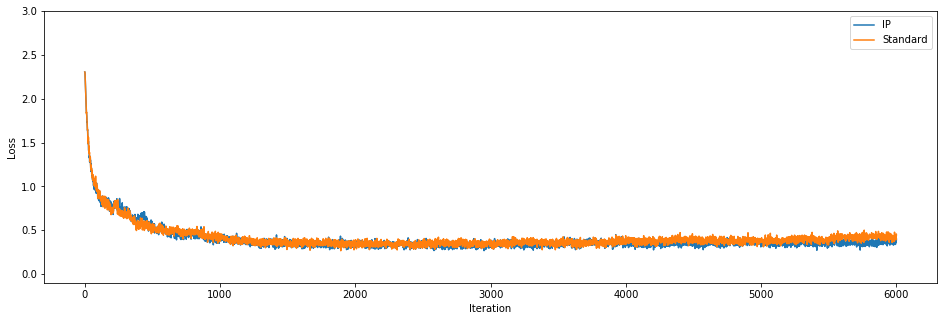

In [9]:
syn_lr = 0.01

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.164
[2] loss: 0.766
[3] loss: 0.602
[4] loss: 0.503
[5] loss: 0.449
[6] loss: 0.422
[7] loss: 0.431
[8] loss: 0.424
[9] loss: 0.435
[10] loss: 0.454
[11] loss: 0.433
[12] loss: 0.450
[13] loss: 0.473
[14] loss: 0.492
[15] loss: 0.466
[16] loss: 0.557
[17] loss: 0.537
[18] loss: 0.522
[19] loss: 0.489
[20] loss: 0.488
Largest beta is  (tensor(0.6392, device='cuda:0'), tensor(25, device='cuda:0'))
Largest weight is  (tensor(4.4149, device='cuda:0'), tensor(377, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.132
[2] loss: 0.904
[3] loss: 0.611
[4] loss: 0.494
[5] loss: 0.436
[6] loss: 0.407
[7] loss: 0.407
[8] loss: 0.452
[9] loss: 0.448
[10] loss: 0.422
[11] loss: 0.447
[12] loss: 0.480
[13] loss: 0.509
[14] loss: 0.529
[15] loss: 0.561
[16] loss: 0.490
[17] loss: 0.556
[18] loss: 0.576
[19] loss: 0.573
[20] loss: 0.601
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4

[8] loss: 1.661
[9] loss: 1.660
[10] loss: 1.728
[11] loss: 1.720
[12] loss: 1.855
[13] loss: 2.089
[14] loss: 2.234
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(3.4944, device='cuda:0'), tensor(48, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 2.073
[2] loss: 2.255
[3] loss: 2.310
[4] loss: 2.310
[5] loss: 2.310
[6] loss: 2.310
[7] loss: 2.310
[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Largest beta is  (tensor(0.6297, device='cuda:0'), tensor(21, device='cuda:0'))
Largest weight is  (tensor(1.1731, device='cuda:0'), tensor(19, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 2.083
[2] loss: 2.151
[3] los

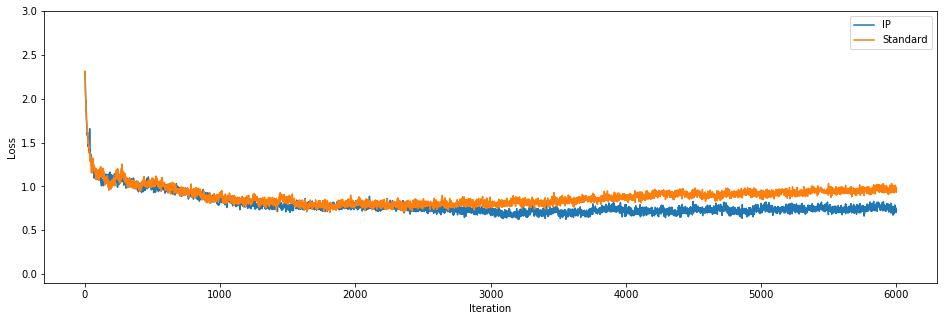

In [10]:
syn_lr = 0.012

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Tests

In [11]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.0001

Training IP Net. Run 1
[1] loss: 2.057
[2] loss: 1.858
[3] loss: 1.791
[4] loss: 1.739
[5] loss: 1.685
[6] loss: 1.639
[7] loss: 1.607
[8] loss: 1.570
[9] loss: 1.548
[10] loss: 1.520
[11] loss: 1.490
[12] loss: 1.477
[13] loss: 1.453
[14] loss: 1.438
[15] loss: 1.418
[16] loss: 1.398
[17] loss: 1.390
[18] loss: 1.367
[19] loss: 1.357
[20] loss: 1.343
[21] loss: 1.327
[22] loss: 1.318
[23] loss: 1.309
[24] loss: 1.295
[25] loss: 1.277
[26] loss: 1.267
[27] loss: 1.261
[28] loss: 1.248
[29] loss: 1.241
[30] loss: 1.233
[31] loss: 1.218
[32] loss: 1.209
[33] loss: 1.199
[34] loss: 1.185
[35] loss: 1.179
[36] loss: 1.166
[37] loss: 1.162
[38] loss: 1.160
[39] loss: 1.137
[40] loss: 1.139
Largest beta is  (tensor(1.1456, device='cuda:0'), tensor(4, device='cuda:0'))
Largest weight is  (tensor(0.2864, device='cuda:0'), tensor(4, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.059
[2] loss: 1.849
[3] loss: 1.786
[4] loss: 1.730
[5] loss: 1.683
[6] loss: 1.626
[

[18] loss: 1.327
[19] loss: 1.320
[20] loss: 1.309
[21] loss: 1.298
[22] loss: 1.276
[23] loss: 1.261
[24] loss: 1.256
[25] loss: 1.238
[26] loss: 1.220
[27] loss: 1.210
[28] loss: 1.208
[29] loss: 1.189
[30] loss: 1.180
[31] loss: 1.170
[32] loss: 1.159
[33] loss: 1.148
[34] loss: 1.129
[35] loss: 1.131
[36] loss: 1.116
[37] loss: 1.105
[38] loss: 1.100
[39] loss: 1.079
[40] loss: 1.086
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.2887, device='cuda:0'), tensor(85, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.057
[2] loss: 1.842
[3] loss: 1.771
[4] loss: 1.723
[5] loss: 1.675
[6] loss: 1.635
[7] loss: 1.592
[8] loss: 1.568
[9] loss: 1.538
[10] loss: 1.524
[11] loss: 1.496
[12] loss: 1.484
[13] loss: 1.450
[14] loss: 1.443
[15] loss: 1.419
[16] loss: 1.403
[17] loss: 1.392
[18] loss: 1.368
[19] loss: 1.364
[20] loss: 1.342
[21] loss: 1.334
[22] loss: 1.324
[23] loss: 1.302
[24] loss: 1.294
[25] loss:

[36] loss: 1.168
[37] loss: 1.169
[38] loss: 1.147
[39] loss: 1.147
[40] loss: 1.143
Largest beta is  (tensor(1.1524, device='cuda:0'), tensor(43, device='cuda:0'))
Largest weight is  (tensor(0.3331, device='cuda:0'), tensor(126, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.154
[2] loss: 1.867
[3] loss: 1.770
[4] loss: 1.705
[5] loss: 1.663
[6] loss: 1.623
[7] loss: 1.591
[8] loss: 1.559
[9] loss: 1.528
[10] loss: 1.494
[11] loss: 1.468
[12] loss: 1.453
[13] loss: 1.436
[14] loss: 1.400
[15] loss: 1.388
[16] loss: 1.371
[17] loss: 1.350
[18] loss: 1.335
[19] loss: 1.321
[20] loss: 1.315
[21] loss: 1.295
[22] loss: 1.271
[23] loss: 1.260
[24] loss: 1.254
[25] loss: 1.237
[26] loss: 1.225
[27] loss: 1.217
[28] loss: 1.210
[29] loss: 1.190
[30] loss: 1.189
[31] loss: 1.175
[32] loss: 1.159
[33] loss: 1.145
[34] loss: 1.136
[35] loss: 1.125
[36] loss: 1.115
[37] loss: 1.111
[38] loss: 1.099
[39] loss: 1.097
[40] loss: 1.084
Largest beta is  (tensor(0., de

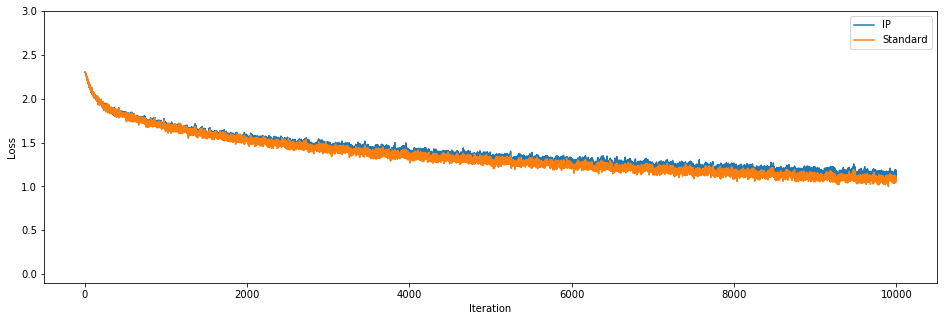

In [13]:
syn_lr = 0.0003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.080
[2] loss: 1.880
[3] loss: 1.811
[4] loss: 1.733
[5] loss: 1.690
[6] loss: 1.661
[7] loss: 1.622
[8] loss: 1.592
[9] loss: 1.565
[10] loss: 1.548
[11] loss: 1.520
[12] loss: 1.513
[13] loss: 1.486
[14] loss: 1.466
[15] loss: 1.438
[16] loss: 1.442
[17] loss: 1.416
[18] loss: 1.409
[19] loss: 1.397
[20] loss: 1.381
[21] loss: 1.378
[22] loss: 1.364
[23] loss: 1.349
[24] loss: 1.338
[25] loss: 1.331
[26] loss: 1.317
[27] loss: 1.313
[28] loss: 1.296
[29] loss: 1.296
[30] loss: 1.280
[31] loss: 1.270
[32] loss: 1.271
[33] loss: 1.262
[34] loss: 1.236
[35] loss: 1.241
[36] loss: 1.227
[37] loss: 1.223
[38] loss: 1.215
[39] loss: 1.208
[40] loss: 1.194
Largest beta is  (tensor(1.1343, device='cuda:0'), tensor(94, device='cuda:0'))
Largest weight is  (tensor(0.5087, device='cuda:0'), tensor(127, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.069
[2] loss: 1.890
[3] loss: 1.797
[4] loss: 1.742
[5] loss: 1.698
[6] loss: 1.66

[18] loss: 1.373
[19] loss: 1.365
[20] loss: 1.348
[21] loss: 1.338
[22] loss: 1.325
[23] loss: 1.310
[24] loss: 1.304
[25] loss: 1.284
[26] loss: 1.282
[27] loss: 1.265
[28] loss: 1.253
[29] loss: 1.247
[30] loss: 1.243
[31] loss: 1.226
[32] loss: 1.211
[33] loss: 1.201
[34] loss: 1.190
[35] loss: 1.188
[36] loss: 1.168
[37] loss: 1.162
[38] loss: 1.155
[39] loss: 1.149
[40] loss: 1.133
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.3710, device='cuda:0'), tensor(2815, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.036
[2] loss: 1.829
[3] loss: 1.760
[4] loss: 1.715
[5] loss: 1.676
[6] loss: 1.642
[7] loss: 1.607
[8] loss: 1.584
[9] loss: 1.556
[10] loss: 1.526
[11] loss: 1.505
[12] loss: 1.480
[13] loss: 1.470
[14] loss: 1.448
[15] loss: 1.434
[16] loss: 1.412
[17] loss: 1.411
[18] loss: 1.376
[19] loss: 1.375
[20] loss: 1.364
[21] loss: 1.352
[22] loss: 1.345
[23] loss: 1.323
[24] loss: 1.317
[25] los

[36] loss: 1.207
[37] loss: 1.205
[38] loss: 1.184
[39] loss: 1.179
[40] loss: 1.169
Largest beta is  (tensor(1.1310, device='cuda:0'), tensor(86, device='cuda:0'))
Largest weight is  (tensor(0.5164, device='cuda:0'), tensor(122, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.071
[2] loss: 1.861
[3] loss: 1.780
[4] loss: 1.724
[5] loss: 1.683
[6] loss: 1.654
[7] loss: 1.613
[8] loss: 1.589
[9] loss: 1.553
[10] loss: 1.536
[11] loss: 1.512
[12] loss: 1.492
[13] loss: 1.465
[14] loss: 1.453
[15] loss: 1.432
[16] loss: 1.420
[17] loss: 1.405
[18] loss: 1.388
[19] loss: 1.383
[20] loss: 1.382
[21] loss: 1.352
[22] loss: 1.343
[23] loss: 1.341
[24] loss: 1.320
[25] loss: 1.306
[26] loss: 1.303
[27] loss: 1.295
[28] loss: 1.283
[29] loss: 1.271
[30] loss: 1.266
[31] loss: 1.246
[32] loss: 1.240
[33] loss: 1.234
[34] loss: 1.222
[35] loss: 1.225
[36] loss: 1.204
[37] loss: 1.193
[38] loss: 1.184
[39] loss: 1.176
[40] loss: 1.171
Largest beta is  (tensor(0., de

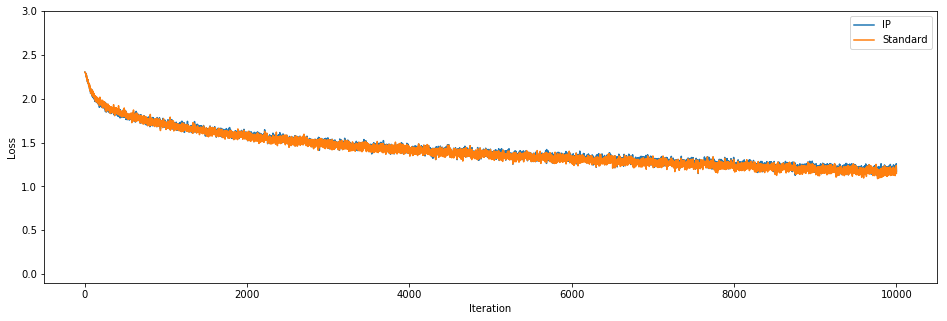

In [14]:
syn_lr = 0.0006

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.049
[2] loss: 1.902
[3] loss: 1.851
[4] loss: 1.798
[5] loss: 1.763
[6] loss: 1.748
[7] loss: 1.731
[8] loss: 1.701
[9] loss: 1.678
[10] loss: 1.663
[11] loss: 1.641
[12] loss: 1.621
[13] loss: 1.608
[14] loss: 1.595
[15] loss: 1.570
[16] loss: 1.552
[17] loss: 1.548
[18] loss: 1.541
[19] loss: 1.530
[20] loss: 1.519
[21] loss: 1.513
[22] loss: 1.515
[23] loss: 1.510
[24] loss: 1.499
[25] loss: 1.499
[26] loss: 1.487
[27] loss: 1.481
[28] loss: 1.475
[29] loss: 1.461
[30] loss: 1.458
[31] loss: 1.443
[32] loss: 1.441
[33] loss: 1.445
[34] loss: 1.440
[35] loss: 1.418
[36] loss: 1.419
[37] loss: 1.415
[38] loss: 1.411
[39] loss: 1.398
[40] loss: 1.398
Largest beta is  (tensor(1.1335, device='cuda:0'), tensor(101, device='cuda:0'))
Largest weight is  (tensor(0.7801, device='cuda:0'), tensor(4, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.081
[2] loss: 1.909
[3] loss: 1.855
[4] loss: 1.798
[5] loss: 1.769
[6] loss: 1.741

[18] loss: 1.521
[19] loss: 1.509
[20] loss: 1.499
[21] loss: 1.493
[22] loss: 1.475
[23] loss: 1.467
[24] loss: 1.477
[25] loss: 1.455
[26] loss: 1.456
[27] loss: 1.447
[28] loss: 1.440
[29] loss: 1.419
[30] loss: 1.416
[31] loss: 1.412
[32] loss: 1.400
[33] loss: 1.396
[34] loss: 1.393
[35] loss: 1.380
[36] loss: 1.378
[37] loss: 1.379
[38] loss: 1.367
[39] loss: 1.346
[40] loss: 1.351
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.7166, device='cuda:0'), tensor(80, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.041
[2] loss: 1.870
[3] loss: 1.816
[4] loss: 1.778
[5] loss: 1.760
[6] loss: 1.726
[7] loss: 1.709
[8] loss: 1.679
[9] loss: 1.655
[10] loss: 1.626
[11] loss: 1.613
[12] loss: 1.605
[13] loss: 1.575
[14] loss: 1.560
[15] loss: 1.541
[16] loss: 1.523
[17] loss: 1.518
[18] loss: 1.508
[19] loss: 1.504
[20] loss: 1.491
[21] loss: 1.468
[22] loss: 1.470
[23] loss: 1.455
[24] loss: 1.450
[25] loss:

[36] loss: 1.417
[37] loss: 1.415
[38] loss: 1.397
[39] loss: 1.386
[40] loss: 1.384
Largest beta is  (tensor(1.1349, device='cuda:0'), tensor(65, device='cuda:0'))
Largest weight is  (tensor(0.8786, device='cuda:0'), tensor(33, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.103
[2] loss: 1.938
[3] loss: 1.876
[4] loss: 1.825
[5] loss: 1.789
[6] loss: 1.767
[7] loss: 1.747
[8] loss: 1.715
[9] loss: 1.709
[10] loss: 1.679
[11] loss: 1.660
[12] loss: 1.644
[13] loss: 1.630
[14] loss: 1.612
[15] loss: 1.604
[16] loss: 1.587
[17] loss: 1.576
[18] loss: 1.559
[19] loss: 1.556
[20] loss: 1.546
[21] loss: 1.536
[22] loss: 1.527
[23] loss: 1.520
[24] loss: 1.511
[25] loss: 1.508
[26] loss: 1.502
[27] loss: 1.489
[28] loss: 1.478
[29] loss: 1.472
[30] loss: 1.458
[31] loss: 1.469
[32] loss: 1.466
[33] loss: 1.442
[34] loss: 1.441
[35] loss: 1.436
[36] loss: 1.433
[37] loss: 1.426
[38] loss: 1.415
[39] loss: 1.411
[40] loss: 1.409
Largest beta is  (tensor(0., dev

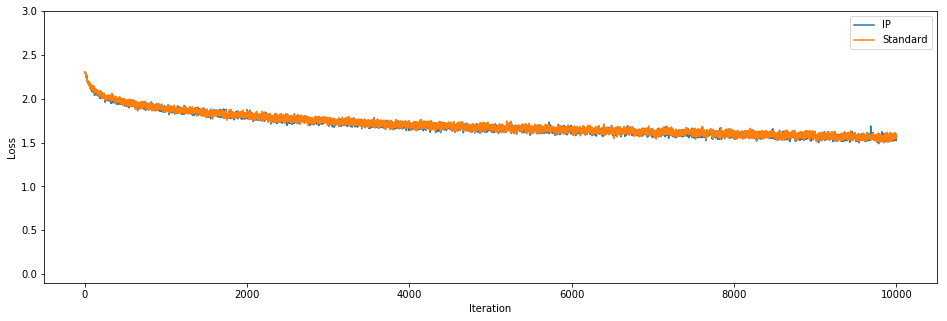

In [15]:
syn_lr = 0.001
run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.316
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 2.312
[17] loss: 2.312
[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(1.1060, device='cuda:0'), tensor(8, device='cuda:0'))
Largest weight is  (tensor(0.2561, device='cuda:0'), tensor(9, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[

[18] loss: 1.984
[19] loss: 2.058
[20] loss: 2.073
[21] loss: 2.222
[22] loss: 2.311
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.3153, device='cuda:0'), tensor(38, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.312
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 2.314
[17] loss: 2.312
[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss:

[37] loss: 2.325
[38] loss: 2.325
[39] loss: 2.325
[40] loss: 2.325
Largest beta is  (tensor(1.0886, device='cuda:0'), tensor(48, device='cuda:0'))
Largest weight is  (tensor(1.0604, device='cuda:0'), tensor(14, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.165
[2] loss: 2.063
[3] loss: 2.023
[4] loss: 1.987
[5] loss: 1.983
[6] loss: 1.963
[7] loss: 1.941
[8] loss: 1.950
[9] loss: 1.945
[10] loss: 1.932
[11] loss: 1.928
[12] loss: 1.921
[13] loss: 1.927
[14] loss: 1.913
[15] loss: 1.909
[16] loss: 1.922
[17] loss: 1.924
[18] loss: 1.919
[19] loss: 1.916
[20] loss: 1.917
[21] loss: 1.931
[22] loss: 1.924
[23] loss: 1.920
[24] loss: 1.934
[25] loss: 1.946
[26] loss: 1.930
[27] loss: 1.919
[28] loss: 1.940
[29] loss: 2.000
[30] loss: 1.955
[31] loss: 1.992
[32] loss: 1.979
[33] loss: 1.936
[34] loss: 1.935
[35] loss: 1.949
[36] loss: 1.958
[37] loss: 1.959
[38] loss: 1.933
[39] loss: 1.961
[40] loss: 2.002
Largest beta is  (tensor(0., device='cuda:0'), te

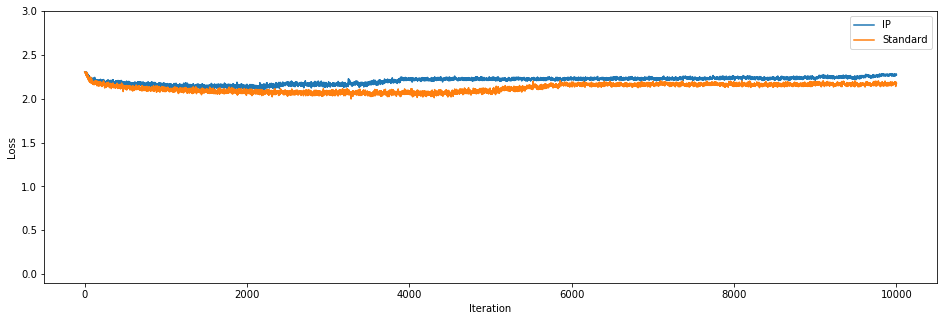

In [16]:
syn_lr = 0.002

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)